In [ ]:
# first read the data from txt files (TSV), and then can do train-val split, after which can train. Work with the data using pandas 
# feature engineering, data imputation (how?) or simply random forest/boosting, use f1 score as the loss function, do cross validation if have the time for it 
# figure out missing data and saturated lab value data, correlation b/w data and data imputation 
# stack multiple strong learners, after doing data imputation consider multiple strong learners (NN, logreg, RANDOM FOREST, etc) 

In [200]:
import xgboost as xgb
import pandas as pd
import sklearn
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV 
from sklearn.impute import SimpleImputer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, make_scorer

In [47]:
# Q: how does xgboost deal with missing data (surrogate splits? need to set to 0? or what?), and how do trees deal with missing data? 

clinical_train_df = pd.read_csv('textfile.txt', sep='\t')
genetic_train_df = pd.read_csv('textfile.txt', sep='\t')
clinical_test_df = pd.read_csv('textfile.txt', sep='\t')
genetic_test_df = pd.read_csv('textfile.txt', sep='\t')

In [67]:
print('Leu', clinical_train_df['Leu'].unique())
print('Hb', clinical_train_df['Hb'].unique())
print('CRP', clinical_train_df['CRP'].unique())
print('ESR', clinical_train_df['ESR'].unique())
print('Fer', clinical_train_df['Fer'].unique())
print('B12', clinical_train_df['B12'].unique())
print('Fol', clinical_train_df['Fol'].unique())
print('Alk', clinical_train_df['Alk'].unique())
print('Alb', clinical_train_df['Alb'].unique())

print(clinical_test_df['CRP'].unique())
print(clinical_test_df['Fol'].unique())
print(clinical_test_df['CRP'])

clinical_train_df.head(10)

Leu [  5.5    7.6     nan  13.6    5.7    7.2   11.1    8.3    7.     6.8
   9.1    9.7    7.4    3.8    4.13   8.     9.3    5.1   12.7    4.9
   4.5    4.7   12.6   10.5    9.5    9.9    6.3    3.7    6.5    5.3
   9.21   8.7    7.7    6.     5.2    3.9    5.8   11.2    5.6    6.9
   5.24   7.1    6.1    5.9   10.4    4.91   7.5   10.    10.9    7.3
  10.8    2.9    8.1    9.8   13.     6.83   8.8    6.4    6.6   11.
  10.1    9.4    7.8   11.76   4.3    5.     8.9   10.2   11.3    5.01
   8.2   10.3    6.7    4.6   12.1    6.32   9.45   9.2    9.    12.
   6.08 131.     3.74   3.5    6.16   8.5   13.3    3.2    5.12   8.4
  14.4    4.2   15.4    3.93   6.2    3.    15.9   10.7    2.3    2.4
   7.9    7.04   8.6   11.8    7.01   9.26  13.2    9.23   2.23  15.8
   7.28   4.16  18.    11.9    3.6    5.4   14.7   11.5    4.33   9.6
   4.76   5.29   4.8    4.06  11.4   16.5    4.4    4.    13.7    5.54
  14.1    6.73   3.1    7.81   3.46  17.1    3.4    6.77   7.77  10.08
   9.95   4.1  

,PatientId,Gender,Height,Weight,Diag,AgeAtDiag,SmokeAtDiag,Leu,Hb,CRP,ESR,Fer,B12,Fol,Alk,Alb
0,1,2,165.0,59.0,0,16.0,0,5.5,120.0,20.0,NaN,NaN,NaN,NaN,61.0,NaN
1,3,2,NaN,NaN,1,31.0,0,7.6,134.0,5.0,8.0,53.0,NaN,NaN,43.0,NaN
2,4,1,174.0,67.0,0,31.0,0,NaN,103.0,40.0,NaN,226.0,299.0,7.9,69.0,35.0
3,5,2,172.0,60.0,1,56.0,1,13.6,104.0,23.0,26.0,NaN,NaN,NaN,87.0,32.0
4,6,1,182.0,74.0,0,22.0,1,5.7,150.0,2.0,NaN,NaN,NaN,NaN,NaN,44.0
5,7,1,179.0,75.0,0,40.0,1,7.2,133.0,NaN,NaN,63.0,135.0,9.5,55.0,41.0
6,9,1,173.0,69.0,1,31.0,0,11.1,133.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN
7,10,1,175.0,89.0,1,37.0,0,8.3,150.0,1.1,NaN,71.0,309.0,NaN,72.0,41.0
8,11,1,174.0,72.0,1,53.0,0,7.0,140.0,2.0,NaN,52.0,NaN,NaN,59.0,38.0
9,12,2,159.0,58.0,0,33.0,0,6.8,133.0,7.1,NaN,NaN,182.0,16.6,87.0,42.0


In [63]:
clinical_train_df['Diag'] = clinical_train_df['Diag'].replace({'CD': 0, 'UC': 1})
clinical_train_df = clinical_train_df.replace({'<3': float('nan'), '<8': float('nan'), 
                                               '<2': float('nan'), '<1': float('nan'),
                                               '<5': float('nan'), '<4': float('nan'),
                                               '<0.8': float('nan'), '<0.7': float('nan'),
                                               '<0.3': float('nan'), '<0.5': float('nan'),
                                               '<0.9': float('nan'), '<10': float('nan'),
                                               '<37': float('nan'), '<45': float('nan'),
                                               '<90': float('nan'), '>1107': float('nan'),
                                               '>11070': float('nan'), '>45': float('nan'), 
                                               '>45.3': float('nan'), '>20': float('nan'),
                                               '>453.2': float('nan'), '>45.4': float('nan'), 
                                               '>24': float('nan')})
clinical_train_df['CRP'] = pd.to_numeric(clinical_train_df['CRP'])   
clinical_train_df['Fer'] = pd.to_numeric(clinical_train_df['Fer']) 
clinical_train_df['B12'] = pd.to_numeric(clinical_train_df['B12']) 
clinical_train_df['Fol'] = pd.to_numeric(clinical_train_df['Fol'])         
             
clinical_test_df.drop(columns=['Leu_signe', 'Hb_signe', 'CRP_signe', 'ESR_signe', 'Fer_signe', 'B12_signe', 'Fol_signe', 'Alk_signe', 'Alb_signe'], inplace=True)
clinical_test_df = clinical_test_df.replace({'<2': float('nan'), '<0.9': float('nan'),
                                             '<8': float('nan'), '<3': float('nan'), 
                                             '<459.2': float('nan')})
clinical_test_df['CRP'] = pd.to_numeric(clinical_test_df['CRP'])
clinical_test_df['Fol'] = pd.to_numeric(clinical_test_df['Fol'])

display(clinical_train_df)
display(genetic_train_df)     
clinical_train_df.info()
genetic_train_df.info()

display(clinical_test_df)
clinical_test_df.info()

#convert objects (saturations <>) into what? also whatever you do to train must do to test do, if applicable 
#for now, convert saturations into NaN 

# combine the genetic and clinical data , optimize hyperparams 

,PatientId,Gender,Height,Weight,Diag,AgeAtDiag,SmokeAtDiag,Leu,Hb,CRP,ESR,Fer,B12,Fol,Alk,Alb
0,1,2,165.0,59.0,0,16.0,0,5.5,120.0,20.0,NaN,NaN,NaN,NaN,61.0,NaN
1,3,2,NaN,NaN,1,31.0,0,7.6,134.0,5.0,8.0,53.0,NaN,NaN,43.0,NaN
2,4,1,174.0,67.0,0,31.0,0,NaN,103.0,40.0,NaN,226.0,299.0,7.9,69.0,35.0
3,5,2,172.0,60.0,1,56.0,1,13.6,104.0,23.0,26.0,NaN,NaN,NaN,87.0,32.0
4,6,1,182.0,74.0,0,22.0,1,5.7,150.0,2.0,NaN,NaN,NaN,NaN,NaN,44.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1985,2026,1,175.0,72.0,0,25.0,1,6.3,153.0,2.3,NaN,33.0,258.0,NaN,52.0,42.0
1986,2027,1,182.0,77.0,0,26.0,-1,9.9,166.0,NaN,NaN,NaN,NaN,NaN,36.0,NaN
1987,2028,1,170.0,68.0,0,22.0,0,4.3,115.0,2.0,10.0,24.0,161.0,8.8,45.0,NaN
1988,2029,1,NaN,NaN,0,16.0,-1,10.3,143.0,15.0,NaN,49.0,NaN,NaN,NaN,37.0


,PatientId,SNP_0,SNP_1,SNP_2,SNP_3,SNP_4,SNP_5,SNP_6,SNP_7,SNP_8,...,SNP_368,SNP_369,SNP_370,SNP_371,SNP_372,SNP_373,SNP_374,SNP_375,SNP_376,SNP_377
0,1883,0.0,-1.0,-1,-1.0,0.0,-1.0,-1.0,0.0,0.0,...,-1.0,0.0,0.0,0.0,-1.0,-1.0,0.0,-1.0,-1.0,0.0
1,530,0.0,-1.0,0,0.0,0.0,-1.0,-1.0,0.0,0.0,...,0.0,-1.0,-1.0,0.0,-1.0,-1.0,0.0,-1.0,-1.0,-1.0
2,1802,0.0,-1.0,0,0.0,-1.0,0.0,0.0,-1.0,-1.0,...,-1.0,0.0,0.0,-1.0,0.0,0.0,0.0,-1.0,-1.0,0.0
3,1110,0.0,-1.0,0,-1.0,0.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,0.0,0.0,0.0,-1.0,-1.0,0.0,-1.0,1.0,0.0
4,1971,-1.0,0.0,-1,-1.0,0.0,0.0,-1.0,0.0,-1.0,...,-1.0,0.0,0.0,1.0,-1.0,-1.0,0.0,-1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1985,276,-1.0,1.0,-1,-1.0,1.0,0.0,-1.0,1.0,0.0,...,-1.0,0.0,0.0,1.0,-1.0,-1.0,0.0,1.0,0.0,0.0
1986,758,-1.0,-1.0,0,-1.0,0.0,0.0,0.0,-1.0,0.0,...,0.0,0.0,0.0,0.0,-1.0,-1.0,0.0,0.0,0.0,-1.0
1987,1870,-1.0,0.0,-1,0.0,0.0,-1.0,-1.0,0.0,1.0,...,-1.0,0.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0
1988,257,-1.0,-1.0,-1,0.0,0.0,-1.0,-1.0,-1.0,0.0,...,1.0,0.0,-1.0,0.0,-1.0,-1.0,1.0,-1.0,-1.0,1.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1990 entries, 0 to 1989
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PatientId    1990 non-null   int64  
 1   Gender       1990 non-null   int64  
 2   Height       1970 non-null   float64
 3   Weight       1973 non-null   float64
 4   Diag         1990 non-null   int64  
 5   AgeAtDiag    1987 non-null   float64
 6   SmokeAtDiag  1990 non-null   int64  
 7   Leu          1899 non-null   float64
 8   Hb           1906 non-null   float64
 9   CRP          1334 non-null   float64
 10  ESR          787 non-null    float64
 11  Fer          1278 non-null   float64
 12  B12          1115 non-null   float64
 13  Fol          952 non-null    float64
 14  Alk          1529 non-null   float64
 15  Alb          1214 non-null   float64
dtypes: float64(12), int64(4)
memory usage: 248.9 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1990 entries, 0 to 1989
Columns: 3

,ID_new,Gender,Height,Weight,AgeAtDiag,SmokeAtDiag,Leu,Hb,CRP,ESR,Fer,B12,Fol,Alk,Alb
0,2,2,163,52,16,1,NaN,NaN,11.0,NaN,NaN,NaN,NaN,NaN,NaN
1,8,1,170,77,59,1,6.90,169.0,NaN,1.0,524.0,128.0,4.4,53.0,NaN
2,13,2,158,49,21,0,13.50,130.0,62.7,30.0,NaN,NaN,NaN,NaN,NaN
3,24,1,180,72,10,0,9.30,150.0,NaN,NaN,43.0,289.0,12.6,68.0,NaN
4,55,2,164,58,34,1,4.50,141.0,NaN,6.0,NaN,NaN,NaN,NaN,NaN
5,62,1,182,80,43,1,4.10,126.0,1.0,NaN,16.0,171.0,25.6,53.0,NaN
6,95,1,168,54,19,1,10.90,127.0,28.0,56.0,630.0,9188.0,NaN,56.0,28.0
7,104,2,150,44,41,1,8.50,113.0,1.0,NaN,36.0,135.0,18.7,82.0,30.0
8,153,1,175,95,34,0,10.70,141.0,9.5,NaN,NaN,NaN,NaN,84.0,NaN
9,159,2,159,55,54,1,15.00,131.0,46.0,40.0,258.0,436.0,840.0,73.0,41.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40 entries, 0 to 39
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ID_new       40 non-null     int64  
 1   Gender       40 non-null     int64  
 2   Height       40 non-null     int64  
 3   Weight       40 non-null     int64  
 4   AgeAtDiag    40 non-null     int64  
 5   SmokeAtDiag  40 non-null     int64  
 6   Leu          38 non-null     float64
 7   Hb           38 non-null     float64
 8   CRP          28 non-null     float64
 9   ESR          19 non-null     float64
 10  Fer          28 non-null     float64
 11  B12          24 non-null     float64
 12  Fol          21 non-null     float64
 13  Alk          31 non-null     float64
 14  Alb          22 non-null     float64
dtypes: float64(9), int64(6)
memory usage: 4.8 KB


In [192]:
train_df = clinical_train_df.join(genetic_train_df.set_index('PatientId'), on='PatientId')
test_df = clinical_test_df.join(genetic_test_df.set_index('PatientId'), on='ID_new')
test_df.rename(columns={'ID_new': 'PatientId'}, inplace=True)
test_df.drop(columns=['PatientId'], inplace=True)
train_df.drop(columns=['PatientId'], inplace=True)
display(train_df)
display(test_df)
display(test_df['SNP_0'].head(), test_df['SNP_1'].head(), test_df['SNP_2'].head())
train_df.info()
test_df.info()

,Gender,Height,Weight,Diag,AgeAtDiag,SmokeAtDiag,Leu,Hb,CRP,ESR,...,SNP_368,SNP_369,SNP_370,SNP_371,SNP_372,SNP_373,SNP_374,SNP_375,SNP_376,SNP_377
0,2,165.0,59.0,0,16.0,0,5.5,120.0,20.0,NaN,...,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN
1,2,NaN,NaN,1,31.0,0,7.6,134.0,5.0,8.0,...,0.0,1.0,0.0,1.0,-1.0,-1.0,-1.0,0.0,1.0,1.0
2,1,174.0,67.0,0,31.0,0,NaN,103.0,40.0,NaN,...,0.0,-1.0,0.0,0.0,0.0,0.0,-1.0,-1.0,0.0,0.0
3,2,172.0,60.0,1,56.0,1,13.6,104.0,23.0,26.0,...,-1.0,-1.0,1.0,0.0,0.0,0.0,-1.0,0.0,-1.0,-1.0
4,1,182.0,74.0,0,22.0,1,5.7,150.0,2.0,NaN,...,0.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1985,1,175.0,72.0,0,25.0,1,6.3,153.0,2.3,NaN,...,1.0,-1.0,0.0,1.0,-1.0,-1.0,0.0,0.0,0.0,-1.0
1986,1,182.0,77.0,0,26.0,-1,9.9,166.0,NaN,NaN,...,-1.0,0.0,1.0,0.0,-1.0,-1.0,0.0,-1.0,-1.0,-1.0
1987,1,170.0,68.0,0,22.0,0,4.3,115.0,2.0,10.0,...,0.0,1.0,0.0,0.0,-1.0,-1.0,0.0,1.0,0.0,0.0
1988,1,NaN,NaN,0,16.0,-1,10.3,143.0,15.0,NaN,...,0.0,0.0,-1.0,1.0,-1.0,-1.0,0.0,-1.0,0.0,0.0


,Gender,Height,Weight,AgeAtDiag,SmokeAtDiag,Leu,Hb,CRP,ESR,Fer,...,SNP_368,SNP_369,SNP_370,SNP_371,SNP_372,SNP_373,SNP_374,SNP_375,SNP_376,SNP_377
0,2,163,52,16,1,NaN,NaN,11.0,NaN,NaN,...,-1,-1,-1,1,-1,-1,0,0,0,-1
1,1,170,77,59,1,6.90,169.0,NaN,1.0,524.0,...,0,1,0,1,-1,-1,0,1,-1,0
2,2,158,49,21,0,13.50,130.0,62.7,30.0,NaN,...,-1,0,-1,-1,0,0,-1,-1,-1,0
3,1,180,72,10,0,9.30,150.0,NaN,NaN,43.0,...,1,-1,0,1,-1,-1,1,0,-1,0
4,2,164,58,34,1,4.50,141.0,NaN,6.0,NaN,...,-1,-1,0,1,-1,-1,-1,-1,0,-1
5,1,182,80,43,1,4.10,126.0,1.0,NaN,16.0,...,1,0,-1,1,-1,-1,-1,0,-1,0
6,1,168,54,19,1,10.90,127.0,28.0,56.0,630.0,...,-1,1,-1,0,-1,-1,1,-1,0,0
7,2,150,44,41,1,8.50,113.0,1.0,NaN,36.0,...,-1,-1,-1,1,-1,-1,0,0,0,0
8,1,175,95,34,0,10.70,141.0,9.5,NaN,NaN,...,-1,-1,0,1,-1,-1,1,0,0,0
9,2,159,55,54,1,15.00,131.0,46.0,40.0,258.0,...,-1,-1,1,0,-1,-1,1,-1,1,0


0   -1
1    0
2   -1
3    0
4   -1
Name: SNP_0, dtype: int64

0    1
1    0
2   -1
3   -1
4   -1
Name: SNP_1, dtype: int64

0    0
1   -1
2   -1
3   -1
4   -1
Name: SNP_2, dtype: int64

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1990 entries, 0 to 1989
Columns: 393 entries, Gender to SNP_377
dtypes: float64(388), int64(5)
memory usage: 6.0 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40 entries, 0 to 39
Columns: 392 entries, Gender to SNP_377
dtypes: float64(48), int64(344)
memory usage: 122.6 KB


In [ ]:
RangeIndex: 1990 entries, 0 to 1989
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PatientId    1990 non-null   int64  
 1   Gender       1990 non-null   int64  
 2   Height       1970 non-null   float64
 3   Weight       1973 non-null   float64
 4   Diag         1990 non-null   int64  
 5   AgeAtDiag    1987 non-null   float64
 6   SmokeAtDiag  1990 non-null   int64  
 7   Leu          1899 non-null   float64
 8   Hb           1906 non-null   float64
 9   CRP          1334 non-null   float64
 10  ESR          787 non-null    float64
 11  Fer          1278 non-null   float64
 12  B12          1115 non-null   float64
 13  Fol          952 non-null    float64
 14  Alk          1529 non-null   float64
 15  Alb          1214 non-null   float64

In [ ]:
# data imputation. Missing values are float('nan'), and these values shall be imputed. All SNPs need to be ints, other medical values that are not ints are floats 
# need to impute: Height, Weight, AgeAtDiag, Leu, Hb, CRP, ESR, Fer, B12, Fol, Alk, Alb. Impute them numerically
# need to impute all SNPs categorically

imputer_numeric = SimpleImputer(missing_values=float('nan'), strategy='mean')
imputer_categorical = SimpleImputer(missing_values=float('nan'), strategy='most_frequent')


In [ ]:
# one hot encoding
# need to one hot encode SmokeAtDiag, Gender, and all SNPs 


In [193]:
# convert dtypes into appropriate dtypes (nans and ints and objects into one hot encoded vects) and then convert into X_train, y_train, X_val, y_val (use stratify), and then do XGBoost.
# for training xgboost, use cross validation and gridsearch()
# convert all categorical data into one hot encoded data (?). set missing to float('nan'). Correlation b/w features and imputation, bayesian hyperparam search, and pipeline way? 
# test_df == X_test ! 
X = train_df.drop(columns=['Diag']).copy()
y = train_df['Diag'].copy() 
display(X)
display(y)
X.info()
y.info()

,Gender,Height,Weight,AgeAtDiag,SmokeAtDiag,Leu,Hb,CRP,ESR,Fer,...,SNP_368,SNP_369,SNP_370,SNP_371,SNP_372,SNP_373,SNP_374,SNP_375,SNP_376,SNP_377
0,2,165.0,59.0,16.0,0,5.5,120.0,20.0,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN
1,2,NaN,NaN,31.0,0,7.6,134.0,5.0,8.0,53.0,...,0.0,1.0,0.0,1.0,-1.0,-1.0,-1.0,0.0,1.0,1.0
2,1,174.0,67.0,31.0,0,NaN,103.0,40.0,NaN,226.0,...,0.0,-1.0,0.0,0.0,0.0,0.0,-1.0,-1.0,0.0,0.0
3,2,172.0,60.0,56.0,1,13.6,104.0,23.0,26.0,NaN,...,-1.0,-1.0,1.0,0.0,0.0,0.0,-1.0,0.0,-1.0,-1.0
4,1,182.0,74.0,22.0,1,5.7,150.0,2.0,NaN,NaN,...,0.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1985,1,175.0,72.0,25.0,1,6.3,153.0,2.3,NaN,33.0,...,1.0,-1.0,0.0,1.0,-1.0,-1.0,0.0,0.0,0.0,-1.0
1986,1,182.0,77.0,26.0,-1,9.9,166.0,NaN,NaN,NaN,...,-1.0,0.0,1.0,0.0,-1.0,-1.0,0.0,-1.0,-1.0,-1.0
1987,1,170.0,68.0,22.0,0,4.3,115.0,2.0,10.0,24.0,...,0.0,1.0,0.0,0.0,-1.0,-1.0,0.0,1.0,0.0,0.0
1988,1,NaN,NaN,16.0,-1,10.3,143.0,15.0,NaN,49.0,...,0.0,0.0,-1.0,1.0,-1.0,-1.0,0.0,-1.0,0.0,0.0


0       0
1       1
2       0
3       1
4       0
       ..
1985    0
1986    0
1987    0
1988    0
1989    1
Name: Diag, Length: 1990, dtype: int64

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1990 entries, 0 to 1989
Columns: 392 entries, Gender to SNP_377
dtypes: float64(388), int64(4)
memory usage: 6.0 MB
<class 'pandas.core.series.Series'>
RangeIndex: 1990 entries, 0 to 1989
Series name: Diag
Non-Null Count  Dtype
--------------  -----
1990 non-null   int64
dtypes: int64(1)
memory usage: 15.7 KB


In [194]:
# X_encoded = do this later 
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, random_state=1337, train_size=0.8, test_size=0.2)
X_train.info()
y_train.info()
X_val.info()
y_val.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1592 entries, 1837 to 797
Columns: 392 entries, Gender to SNP_377
dtypes: float64(388), int64(4)
memory usage: 4.8 MB
<class 'pandas.core.series.Series'>
Int64Index: 1592 entries, 1837 to 797
Series name: Diag
Non-Null Count  Dtype
--------------  -----
1592 non-null   int64
dtypes: int64(1)
memory usage: 24.9 KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 398 entries, 633 to 335
Columns: 392 entries, Gender to SNP_377
dtypes: float64(388), int64(4)
memory usage: 1.2 MB
<class 'pandas.core.series.Series'>
Int64Index: 398 entries, 633 to 335
Series name: Diag
Non-Null Count  Dtype
--------------  -----
398 non-null    int64
dtypes: int64(1)
memory usage: 6.2 KB


In [ ]:
dtrain = xgb.DMatrix(X_train, label=y_train, missing=float('nan'))  #why do this?? difference between xgb.train and xgb.XGBClassifier?? 
dval = xgb.DMatrix(X_val, label=y_val, missing=float('nan'))

In [108]:
model = xgb.XGBClassifier(objective='binary:logistic', booster='gbtree', missing=float('nan'))  
model.fit(X_train, y_train, verbose=True, eval_set=[(X_val, y_val)], eval_metric='aucpr', early_stopping_rounds=50)

[0]	validation_0-aucpr:0.49716
[1]	validation_0-aucpr:0.51795
[2]	validation_0-aucpr:0.52961
[3]	validation_0-aucpr:0.55708
[4]	validation_0-aucpr:0.56662
[5]	validation_0-aucpr:0.58743
[6]	validation_0-aucpr:0.61509
[7]	validation_0-aucpr:0.62108
[8]	validation_0-aucpr:0.61148
[9]	validation_0-aucpr:0.62175
[10]	validation_0-aucpr:0.61868
[11]	validation_0-aucpr:0.61763
[12]	validation_0-aucpr:0.63445
[13]	validation_0-aucpr:0.64241
[14]	validation_0-aucpr:0.63115
[15]	validation_0-aucpr:0.63260
[16]	validation_0-aucpr:0.63560
[17]	validation_0-aucpr:0.63733
[18]	validation_0-aucpr:0.63908
[19]	validation_0-aucpr:0.64384
[20]	validation_0-aucpr:0.64165
[21]	validation_0-aucpr:0.63688
[22]	validation_0-aucpr:0.63611
[23]	validation_0-aucpr:0.63604
[24]	validation_0-aucpr:0.62937
[25]	validation_0-aucpr:0.63669
[26]	validation_0-aucpr:0.63700
[27]	validation_0-aucpr:0.64432
[28]	validation_0-aucpr:0.64578
[29]	validation_0-aucpr:0.64483
[30]	validation_0-aucpr:0.64488
[31]	validation_0-

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

0.667349472206432


c:\Users\Temirkul\anaconda3\envs\temirkul\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


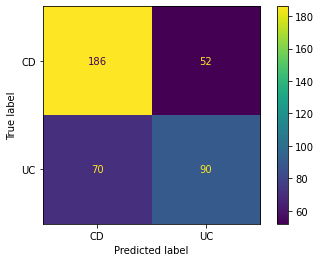

In [106]:
print(model.get_booster())
plot_confusion_matrix(model, X_val, y_val, values_format='d', display_labels=['CD', 'UC'])

In [114]:
# hyperparam optimization, also look at data correlation and feature importance. Compute f1 score on the test set 
# ROUND 1
param_grid = {'max_depth': [1, 2, 3, 4, 5],
              'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2],
              'gamma': [0, 0.25, 0.5],
              'scale_pos_weight': [0.5, 1, 1.5, 2, 2.5, 3],
              'reg_lambda': [0, 1.0, 5.0]
              }
optimal_params = GridSearchCV(estimator=xgb.XGBClassifier(objective='binary:logistic', booster='gbtree', missing=float('nan')), 
                              param_grid=param_grid,
                              scoring='f1',
                              verbose=3,
                              n_jobs=10,
                              cv=5
                              )
optimal_params.fit(X_train, y_train, verbose=True, eval_set=[(X_val, y_val)], eval_metric='auc', early_stopping_rounds=50)

Fitting 5 folds for each of 1350 candidates, totalling 6750 fits
[0]	validation_0-auc:0.67080
[1]	validation_0-auc:0.67080
[2]	validation_0-auc:0.67080
[3]	validation_0-auc:0.68645
[4]	validation_0-auc:0.68645
[5]	validation_0-auc:0.71401
[6]	validation_0-auc:0.73810
[7]	validation_0-auc:0.72374


c:\Users\Temirkul\anaconda3\envs\temirkul\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\Temirkul\anaconda3\envs\temirkul\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[8]	validation_0-auc:0.72374
[9]	validation_0-auc:0.73292
[10]	validation_0-auc:0.72640
[11]	validation_0-auc:0.73258
[12]	validation_0-auc:0.73394
[13]	validation_0-auc:0.73204
[14]	validation_0-auc:0.74580
[15]	validation_0-auc:0.74838
[16]	validation_0-auc:0.75130
[17]	validation_0-auc:0.74589
[18]	validation_0-auc:0.75144
[19]	validation_0-auc:0.75189
[20]	validation_0-auc:0.75167
[21]	validation_0-auc:0.75280
[22]	validation_0-auc:0.74890
[23]	validation_0-auc:0.74819
[24]	validation_0-auc:0.75458
[25]	validation_0-auc:0.75571
[26]	validation_0-auc:0.75702
[27]	validation_0-auc:0.75385
[28]	validation_0-auc:0.76025
[29]	validation_0-auc:0.76341
[30]	validation_0-auc:0.76289
[31]	validation_0-auc:0.76384
[32]	validation_0-auc:0.76155
[33]	validation_0-auc:0.76287
[34]	validation_0-auc:0.76387
[35]	validation_0-auc:0.76406
[36]	validation_0-auc:0.76296
[37]	validation_0-auc:0.76321
[38]	validation_0-auc:0.76564
[39]	validation_0-auc:0.76530
[40]	validation_0-auc:0.76490
[41]	validat

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster='gbtree',
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=N...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                         

In [116]:
print(optimal_params.best_params_)      #now evaluate model on val set and compute f1 score and ..? stacking other strong learners. Consider other hyperparam searching algos. One hot encoding, feature engineering 

{'gamma': 0, 'learning_rate': 0.2, 'max_depth': 1, 'reg_lambda': 0, 'scale_pos_weight': 2.5}


In [162]:
# hyperparam optimization, also look at data correlation and feature importance. Compute f1 score on the test set 
# ROUND 2
param_grid = {'max_depth': [1],
              'learning_rate': [0.2, 0.3, 0.4, 0.5],
              'gamma': [0],
              'scale_pos_weight': [0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4],
              'reg_lambda': [0]
              }
optimal_params = GridSearchCV(estimator=xgb.XGBClassifier(objective='binary:logistic', booster='gbtree', missing=float('nan')), 
                              param_grid=param_grid,
                              scoring='f1',
                              verbose=3,
                              n_jobs=10,
                              cv=5
                              )
optimal_params.fit(X_train, y_train, verbose=True, eval_set=[(X_val, y_val)], eval_metric='auc', early_stopping_rounds=50)

Fitting 5 folds for each of 32 candidates, totalling 160 fits
[0]	validation_0-auc:0.67080
[1]	validation_0-auc:0.67080
[2]	validation_0-auc:0.67080
[3]	validation_0-auc:0.68645
[4]	validation_0-auc:0.68645
[5]	validation_0-auc:0.71401
[6]	validation_0-auc:0.73810
[7]	validation_0-auc:0.72374
[8]	validation_0-auc:0.72374
[9]	validation_0-auc:0.73292
[10]	validation_0-auc:0.72640


c:\Users\Temirkul\anaconda3\envs\temirkul\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\Temirkul\anaconda3\envs\temirkul\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[11]	validation_0-auc:0.73258
[12]	validation_0-auc:0.73394
[13]	validation_0-auc:0.73204
[14]	validation_0-auc:0.74580
[15]	validation_0-auc:0.74838
[16]	validation_0-auc:0.75130
[17]	validation_0-auc:0.74589
[18]	validation_0-auc:0.75144
[19]	validation_0-auc:0.75189
[20]	validation_0-auc:0.75167
[21]	validation_0-auc:0.75280
[22]	validation_0-auc:0.74890
[23]	validation_0-auc:0.74819
[24]	validation_0-auc:0.75458
[25]	validation_0-auc:0.75571
[26]	validation_0-auc:0.75702
[27]	validation_0-auc:0.75385
[28]	validation_0-auc:0.76025
[29]	validation_0-auc:0.76341
[30]	validation_0-auc:0.76289
[31]	validation_0-auc:0.76384
[32]	validation_0-auc:0.76155
[33]	validation_0-auc:0.76287
[34]	validation_0-auc:0.76387
[35]	validation_0-auc:0.76406
[36]	validation_0-auc:0.76296
[37]	validation_0-auc:0.76321
[38]	validation_0-auc:0.76564
[39]	validation_0-auc:0.76530
[40]	validation_0-auc:0.76490
[41]	validation_0-auc:0.76485
[42]	validation_0-auc:0.76471
[43]	validation_0-auc:0.76324
[44]	valid

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster='gbtree',
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=N...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                   

In [163]:
print(optimal_params.best_params_)  

{'gamma': 0, 'learning_rate': 0.2, 'max_depth': 1, 'reg_lambda': 0, 'scale_pos_weight': 2.5}


In [164]:
# hyperparam optimization, also look at data correlation and feature importance. Compute f1 score on the test set 
# ROUND 3
param_grid = {'max_depth': [1],
              'learning_rate': [0.1, 0.2, 0.3],
              'gamma': [0],
              'scale_pos_weight': [2, 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9, 3],
              'reg_lambda': [0]
              }
optimal_params = GridSearchCV(estimator=xgb.XGBClassifier(objective='binary:logistic', booster='gbtree', missing=float('nan')), 
                              param_grid=param_grid,
                              scoring='f1',
                              verbose=3,
                              n_jobs=10,
                              cv=5
                              )
optimal_params.fit(X_train, y_train, verbose=True, eval_set=[(X_val, y_val)], eval_metric='auc', early_stopping_rounds=50)

Fitting 5 folds for each of 33 candidates, totalling 165 fits
[0]	validation_0-auc:0.67080
[1]	validation_0-auc:0.67080
[2]	validation_0-auc:0.67080
[3]	validation_0-auc:0.68645
[4]	validation_0-auc:0.68645
[5]	validation_0-auc:0.71401
[6]	validation_0-auc:0.73810
[7]	validation_0-auc:0.72374
[8]	validation_0-auc:0.72374
[9]	validation_0-auc:0.73292
[10]	validation_0-auc:0.72640


c:\Users\Temirkul\anaconda3\envs\temirkul\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\Temirkul\anaconda3\envs\temirkul\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[11]	validation_0-auc:0.73258
[12]	validation_0-auc:0.73394
[13]	validation_0-auc:0.73204
[14]	validation_0-auc:0.74580
[15]	validation_0-auc:0.74838
[16]	validation_0-auc:0.75130
[17]	validation_0-auc:0.74589
[18]	validation_0-auc:0.75144
[19]	validation_0-auc:0.75189
[20]	validation_0-auc:0.75167
[21]	validation_0-auc:0.75280
[22]	validation_0-auc:0.74890
[23]	validation_0-auc:0.74819
[24]	validation_0-auc:0.75458
[25]	validation_0-auc:0.75571
[26]	validation_0-auc:0.75702
[27]	validation_0-auc:0.75385
[28]	validation_0-auc:0.76025
[29]	validation_0-auc:0.76341
[30]	validation_0-auc:0.76289
[31]	validation_0-auc:0.76384
[32]	validation_0-auc:0.76155
[33]	validation_0-auc:0.76287
[34]	validation_0-auc:0.76387
[35]	validation_0-auc:0.76406
[36]	validation_0-auc:0.76296
[37]	validation_0-auc:0.76321
[38]	validation_0-auc:0.76564
[39]	validation_0-auc:0.76530
[40]	validation_0-auc:0.76490
[41]	validation_0-auc:0.76485
[42]	validation_0-auc:0.76471
[43]	validation_0-auc:0.76324
[44]	valid

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster='gbtree',
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=N...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                   

In [165]:
print(optimal_params.best_params_)  

{'gamma': 0, 'learning_rate': 0.2, 'max_depth': 1, 'reg_lambda': 0, 'scale_pos_weight': 2.5}


In [195]:
model = xgb.XGBClassifier(objective='binary:logistic', booster='gbtree', missing=float('nan'), gamma=0, learning_rate=0.2, max_depth=1, reg_lambda=0, scale_pos_weight=2.5)  #HOT TO RETURN THE BEST MODEL ??
model.fit(X_train, y_train, verbose=True, eval_set=[(X_val, y_val)], eval_metric='aucpr', early_stopping_rounds=50)

[0]	validation_0-aucpr:0.51826
[1]	validation_0-aucpr:0.51826
[2]	validation_0-aucpr:0.51826
[3]	validation_0-aucpr:0.53302
[4]	validation_0-aucpr:0.53302
[5]	validation_0-aucpr:0.56313
[6]	validation_0-aucpr:0.60809
[7]	validation_0-aucpr:0.58978


c:\Users\Temirkul\anaconda3\envs\temirkul\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\Temirkul\anaconda3\envs\temirkul\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[8]	validation_0-aucpr:0.58978
[9]	validation_0-aucpr:0.59781
[10]	validation_0-aucpr:0.58132
[11]	validation_0-aucpr:0.59781
[12]	validation_0-aucpr:0.59916
[13]	validation_0-aucpr:0.59663
[14]	validation_0-aucpr:0.63046
[15]	validation_0-aucpr:0.64201
[16]	validation_0-aucpr:0.66143
[17]	validation_0-aucpr:0.64448
[18]	validation_0-aucpr:0.66429
[19]	validation_0-aucpr:0.66458
[20]	validation_0-aucpr:0.66605
[21]	validation_0-aucpr:0.66474
[22]	validation_0-aucpr:0.66130
[23]	validation_0-aucpr:0.66166
[24]	validation_0-aucpr:0.67098
[25]	validation_0-aucpr:0.67220
[26]	validation_0-aucpr:0.67995
[27]	validation_0-aucpr:0.66308
[28]	validation_0-aucpr:0.67318
[29]	validation_0-aucpr:0.67854
[30]	validation_0-aucpr:0.68081
[31]	validation_0-aucpr:0.68004
[32]	validation_0-aucpr:0.68026
[33]	validation_0-aucpr:0.68083
[34]	validation_0-aucpr:0.68127
[35]	validation_0-aucpr:0.68143
[36]	validation_0-aucpr:0.68124
[37]	validation_0-aucpr:0.67936
[38]	validation_0-aucpr:0.68745
[39]	valid

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=1, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

c:\Users\Temirkul\anaconda3\envs\temirkul\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


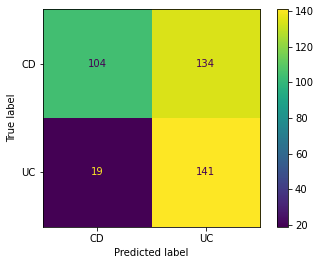

In [196]:
plot_confusion_matrix(model, X_val, y_val, values_format='d', display_labels=['CD', 'UC'])

In [140]:
y_test = model.predict(test_df)
print(y_test)
print(len(y_test))
print(test_df['PatientId'].index)
for i in range(len(y_test)):
    print(test_df['PatientId'][i], y_test[i])

[1 0 1 1 0 0 0 0 1 0 1 1 1 1 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0
 1 1 1]
40
RangeIndex(start=0, stop=40, step=1)
2 1
8 0
13 1
24 1
55 0
62 0
95 0
104 0
153 1
159 0
207 1
215 1
217 1
372 1
878 1
887 0
928 1
935 0
1125 1
1138 0
2025 1
2015 1
1985 1
1965 1
1909 1
1889 1
1758 1
1740 1
1731 1
1724 1
1679 1
1677 1
1601 1
1493 1
1457 1
1455 1
898 0
867 1
247 1
246 1


In [143]:
import csv
with open('preds.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['PatientId', 'Diag'])
    for i in range(len(y_test)):
        writer.writerow([test_df['PatientId'][i], y_test[i]])

In [161]:
preds = pd.read_csv('C:/Users/Temirkul/Desktop/Temirkul/hackathon quantori/preds.csv')
preds.head()
preds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40 entries, 0 to 39
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   PatientId  40 non-null     int64
 1   Diag       40 non-null     int64
dtypes: int64(2)
memory usage: 768.0 bytes


In [197]:
val_preds = model.predict(X_val)
y_val_arr = y_val.to_numpy()
f1_score = sklearn.metrics.f1_score(y_val_arr, val_preds)
print('F1 SCORE ON VAL DATASET:', f1_score)

F1 SCORE ON VAL DATASET: 0.6482758620689655


(392,)


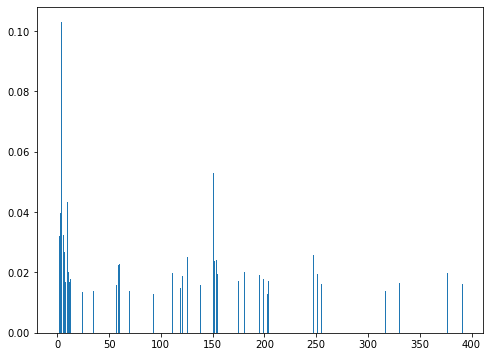

4


In [198]:
# print feature importance and correlations, and consider using cols per tree and sampling and stuff per tree
# DATA IMPUTATION, DROP THE PATIENT ID COLUMN, ONE HOT ENCODE, random forest and stacking models
print(model.feature_importances_.shape)
fig = plt.figure(figsize=(8,6))
plt.bar(range(len(model.feature_importances_)), model.feature_importances_)
plt.show()
print(np.argmax(model.feature_importances_))

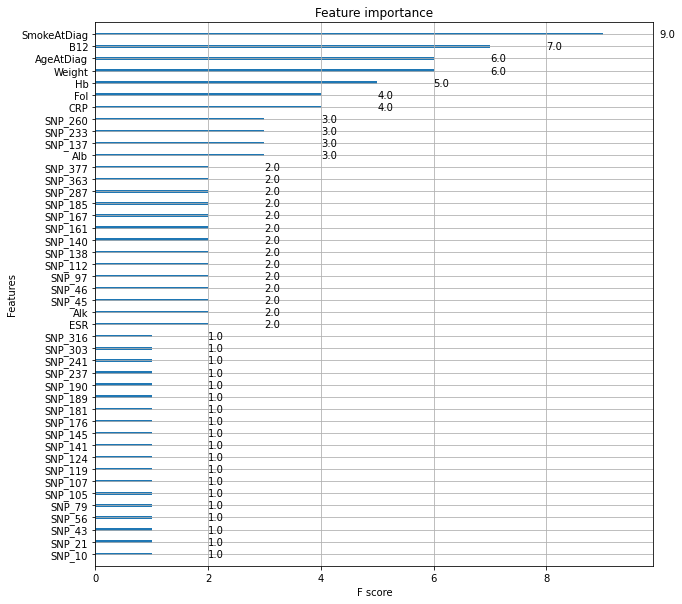

In [199]:
fig = plt.figure(figsize=(10,10))
xgb.plot_importance(model, ax=plt.gca())
plt.show()